In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R


In [2]:
def convert_to_euler_angles(df):
    '''
    Converts the quaternions in the dataframe to euler angles
    '''
    df['theta'] = np.nan
    for i in range(len(df)):
       r = R.from_quat([df['qx'][i], df['qy'][i], df['qz'][i], df['qw'][i]])
       #df.loc[i, 'roll'], df.loc[i, 'pitch'], df.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       _,_, df.loc[i, 'theta'] = r.as_euler('xyz', degrees=True)
       
    return df

In [3]:
df = pd.read_csv('../Aufnahmen/data/odom.csv')
print(df.head())
df = convert_to_euler_angles(df)
df.drop(['z','qx', 'qy', 'qz', 'qw'], axis=1, inplace=True)
df.to_csv('../Aufnahmen/data/poses.csv', index=False)
df.head()


                     datetime         x         y    z   qx   qy        qz  \
0  2023-06-29 13:55:44.614539 -0.503331  0.912730  0.0  0.0  0.0  0.195900   
1  2023-06-29 13:55:44.639550 -0.484567  0.920539  0.0  0.0  0.0  0.203749   
2  2023-06-29 13:55:44.661994 -0.468499  0.927529  0.0  0.0  0.0  0.210507   
3  2023-06-29 13:55:44.679507 -0.455352  0.933466  0.0  0.0  0.0  0.216062   
4  2023-06-29 13:55:44.699996 -0.440248  0.940495  0.0  0.0  0.0  0.222506   

         qw  
0  0.980624  
1  0.979023  
2  0.977592  
3  0.976380  
4  0.974931  


,datetime,x,y,theta
0,2023-06-29 13:55:44.614539,-0.503331,0.912730,22.594556
1,2023-06-29 13:55:44.639550,-0.484567,0.920539,23.512605
2,2023-06-29 13:55:44.661994,-0.468499,0.927529,24.304094
3,2023-06-29 13:55:44.679507,-0.455352,0.933466,24.955724
4,2023-06-29 13:55:44.699996,-0.440248,0.940495,25.712518


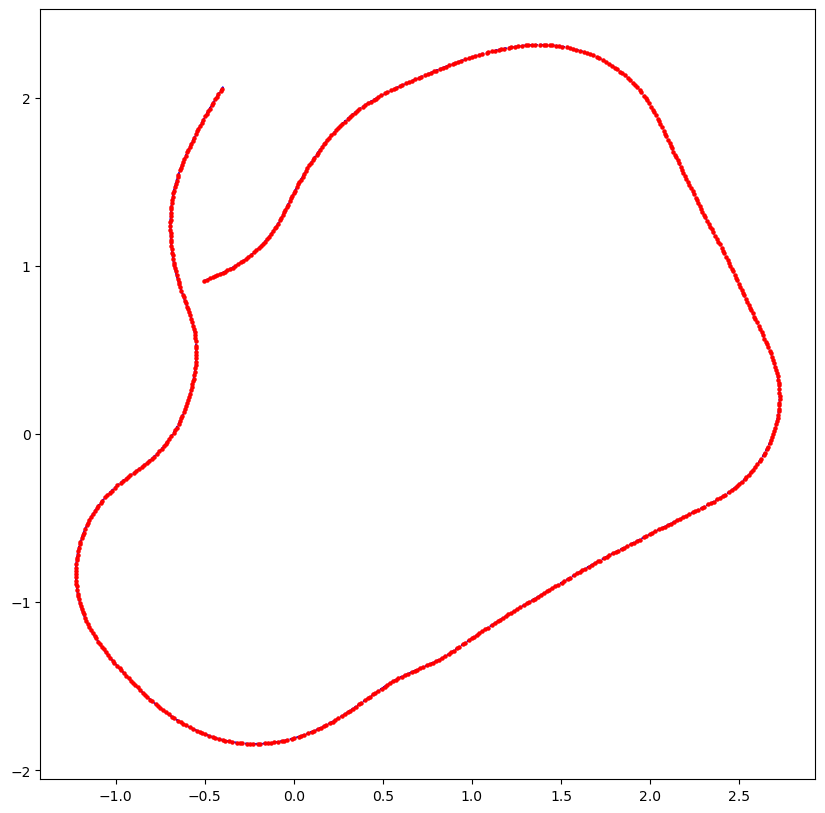

In [6]:
#visualize the trajectory
plt.figure(figsize=(10,10))
nr_points = 700
# Add arrows to indicate the direction
for i in range(nr_points):
    dx = 0.003*np.cos(np.radians(df['theta'][i]))  # calculate the change in x
    dy = 0.003*np.sin(np.radians(df['theta'][i]))  # calculate the change in y
    plt.arrow(df['x'][i], df['y'][i], dx, dy, head_width=0.005, head_length=0.01, fc='blue', ec='blue')
plt.scatter(df['x'][:nr_points], df['y'][:nr_points],s=5, c='red')
plt.show()

In [17]:
import pandas as pd
df_frames =pd.read_csv('../Aufnahmen/data/correctedCurvature.csv')
df_frames['datetime'] = pd.to_datetime(df_frames['datetime'])
last = df_frames['datetime'].iloc[-1]
print('last datetime: ',last)
print(df_frames.tail())

df_poses = pd.read_csv('../Aufnahmen/data/poses.csv')
df_poses['datetime'] = pd.to_datetime(df_poses['datetime'])
#remove all poses after last frame
df_poses = df_poses[df_poses['datetime'] <= last]
print(df_poses.tail())

df_imu = pd.read_csv('../Aufnahmen/data/imu.csv')
df_yawrate = df_imu[['datetime','angular_velocity_z']]
df_yawrate = df_yawrate.rename(columns={'angular_velocity_z':'yawrate'})
df_yawrate['datetime'] = pd.to_datetime(df_yawrate['datetime'])
df_yawrate = df_yawrate[df_yawrate['datetime'] <= last]
print(df_yawrate.tail())
df_yawrate['interval'] =pd.cut(df_yawrate['datetime'], df_poses['datetime'],include_lowest=True)
yaw_grouped = df_yawrate.groupby('interval').mean().reset_index()
yaw_grouped['datetime'] = yaw_grouped['interval'].apply(lambda x: x.right)
yaw_grouped = yaw_grouped.drop(columns=['interval'])
yaw_grouped['datetime'] = pd.to_datetime(yaw_grouped['datetime'])

#repeat missing values
df_merged = pd.merge_asof(df_poses,df_yawrate, on='datetime', direction='nearest')
df_merged = pd.merge_asof(df_merged, df_frames,  on='datetime', direction='nearest')
df_merged = df_merged.drop(columns=['interval','speed'])
print(df_merged[:30])
df_merged.to_csv('../Aufnahmen/data/sgdVars.csv', index=False)
# df_merged.tail()

last datetime:  2023-06-29 13:56:44.486404
      curvature     speed                   datetime
997    0.001869  1.042172 2023-06-29 13:56:44.316476
998    0.008844  1.036637 2023-06-29 13:56:44.356459
999    0.013509  1.018977 2023-06-29 13:56:44.386446
1000   0.016822  1.020295 2023-06-29 13:56:44.461415
1001   0.299817  1.039800 2023-06-29 13:56:44.486404
                       datetime         x         y       theta
2989 2023-06-29 13:56:44.399658  0.648337 -1.373771 -148.903306
2990 2023-06-29 13:56:44.419877  0.630225 -1.384696 -150.095568
2991 2023-06-29 13:56:44.434563  0.616927 -1.392344 -150.960258
2992 2023-06-29 13:56:44.455572  0.598187 -1.402748 -152.057096
2993 2023-06-29 13:56:44.474402  0.580890 -1.411924 -153.059048
                        datetime   yawrate
23675 2023-06-29 13:56:44.476408  0.101229
23676 2023-06-29 13:56:44.478908  0.075049
23677 2023-06-29 13:56:44.481407  0.045379
23678 2023-06-29 13:56:44.483905  0.017453
23679 2023-06-29 13:56:44.486404 -0.0069

C:\Users\ue\AppData\Local\Temp\ipykernel_6028\40819936.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yaw_grouped = df_yawrate.groupby('interval').mean().reset_index()


                     datetime         x         y      theta   yawrate  \
0  2023-06-29 13:55:44.614539 -0.503331  0.912730  22.594556 -0.003491   
1  2023-06-29 13:55:44.639550 -0.484567  0.920539  23.512605  0.024435   
2  2023-06-29 13:55:44.661994 -0.468499  0.927529  24.304094 -0.036652   
3  2023-06-29 13:55:44.679507 -0.455352  0.933466  24.955724 -0.102974   
4  2023-06-29 13:55:44.699996 -0.440248  0.940495  25.712518 -0.099484   
5  2023-06-29 13:55:44.714344 -0.429757  0.945547  26.241463 -0.017453   
6  2023-06-29 13:55:44.739455 -0.411573  0.954511  27.162433 -0.204204   
7  2023-06-29 13:55:44.759530 -0.397285  0.961842  27.891923 -0.122173   
8  2023-06-29 13:55:44.774243 -0.386900  0.967339  28.425700  0.040143   
9  2023-06-29 13:55:44.794230 -0.372538  0.975113  29.167563  0.038397   
10 2023-06-29 13:55:44.814488 -0.357931  0.983266  30.413450  0.031416   
11 2023-06-29 13:55:44.834581 -0.343494  0.991741  31.660249  0.125664   
12 2023-06-29 13:55:44.854470 -0.32902

In [20]:
import numpy as np
import pandas as pd
#get pose indices of match datetimes:
matches = ['2023-06-29 13:55:47.659475',
            '2023-06-29 13:55:59.475904',
            '2023-06-29 13:56:11.238479',
            '2023-06-29 13:56:22.936184',
            '2023-06-29 13:56:34.268945']

df_poses = pd.read_csv('../Aufnahmen/data/poses.csv')
df_poses['datetime'] = pd.to_datetime(df_poses['datetime'])
print(df_poses.head())
for dt in matches:
    dt = pd.to_datetime(dt)
    #find index of closest datetime
    idx = (np.abs(df_poses['datetime'] - dt)).idxmin()
    print(f'idx of datetime {dt}: {idx} ')

                    datetime         x         y      theta
0 2023-06-29 13:55:44.614539 -0.503331  0.912730  22.594556
1 2023-06-29 13:55:44.639550 -0.484567  0.920539  23.512605
2 2023-06-29 13:55:44.661994 -0.468499  0.927529  24.304094
3 2023-06-29 13:55:44.679507 -0.455352  0.933466  24.955724
4 2023-06-29 13:55:44.699996 -0.440248  0.940495  25.712518
idx of datetime 2023-06-29 13:55:47.659475: 152 
idx of datetime 2023-06-29 13:55:59.475904: 743 
idx of datetime 2023-06-29 13:56:11.238479: 1331 
idx of datetime 2023-06-29 13:56:22.936184: 1916 
idx of datetime 2023-06-29 13:56:34.268945: 2483 


In [1]:
import pandas as pd
matches =  [[(53, 76), (252, 266), (444, 460), (649, 664), (827, 843)], [(98, 138), (297, 331), (485, 512), (684, 717), (873, 909)]]
df = pd.read_csv('../Aufnahmen/data/correctedCurvature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df_poses = pd.read_csv('../Aufnahmen/data/poses.csv')
df_poses['datetime'] = pd.to_datetime(df_poses['datetime'])
match_poses = []
for i,matchtype  in enumerate(matches):
    print(f'sequence {i+1}: ')
    matchtype_poses = []
    for j,match in enumerate(matchtype):
        timestart,timeend = df.loc[match[0],'datetime'],df.loc[match[1],'datetime']
        #find index of pose with closest time 
        idx_start = df_poses['datetime'].sub(timestart).abs().idxmin()
        idx_end = df_poses['datetime'].sub(timeend).abs().idxmin()
        matchtype_poses.append((idx_start,idx_end))
    match_poses.append(matchtype_poses)
print('match poses: ',match_poses)


sequence 1: 
sequence 2: 
match poses:  [[(152, 211), (743, 783), (1331, 1389), (1916, 1966), (2483, 2539)], [(278, 391), (871, 965), (1460, 1550), (2049, 2138), (2614, 2711)]]


In [6]:
import pandas as pd
from scipy.spatial.transform import Rotation as R
def convert_to_euler_angles(df):
    '''
    Converts the quaternions in the dataframe to euler angles
    '''
    df_ha = pd.DataFrame(columns=['heading_angle'])
    for i in range(len(df)):
       r = R.from_quat([df['qx'][i], df['qy'][i], df['qz'][i], df['qw'][i]])
       #df.loc[i, 'roll'], df.loc[i, 'pitch'], df.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       _,_, df_ha.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       
    return df_ha
df_odom = pd.read_csv('../Aufnahmen/data/odom.csv')
df_heading = convert_to_euler_angles(df_odom)
df_heading['datetime'] = df_odom['datetime']
df_heading['datetime'] = pd.to_datetime(df_heading['datetime'])
#make datetime column the index
df_heading = df_heading.set_index('datetime')
df_heading.head()
print('max min heading angle: ', df_heading['heading_angle'].max(), df_heading['heading_angle'].min())
#df_heading.to_csv('../Aufnahmen/data/heading_angles.csv')

max min heading angle:  179.9811204165528 -179.99866744669612


In [31]:
import pandas as pd
import numpy as np
df_measurements = pd.read_csv('../Aufnahmen/data/frame_measurements.csv')
df_measurements['datetime'] = pd.to_datetime(df_measurements['datetime'])
print(df_measurements.head())
df_heading['datetime'] = pd.to_datetime(df_heading['datetime'])
df = pd.merge_asof(df_measurements, df_heading, on='datetime', direction='nearest')
df.head()
df_ackermann = pd.read_csv('../Aufnahmen/data/ackermann.csv')
df_ackermann['datetime'] = pd.to_datetime(df_ackermann['datetime'])
df = pd.merge_asof(df, df_ackermann, on='datetime', direction='nearest')
#calculate average time between measurements
avg_time = np.mean(np.diff(df['datetime']))
#convert to seconds
avg_time = avg_time / np.timedelta64(1, 's')
#calculate derivative of curvature
# dKdt = np.gradient(df['curvature'],np.diff(df['datetime']))
# df['der_curvature'] = dKdt
#sort columns as datetime, lateral offset, heading angle, curvature, derivative of curvature, speed, steering angle
df = df[['datetime', 'lateral_offset', 'heading_angle', 'curvature', 'speed', 'steering_angle']]

df.to_csv('../Aufnahmen/data/kalmanVars.csv', index=True)
df.head()

   curvature                   datetime  lateral_offset
0  -0.009975 2023-06-29 13:55:44.785644              20
1  -0.010524 2023-06-29 13:55:44.875628              11
2  -0.010902 2023-06-29 13:55:44.965611               3
3  -0.017683 2023-06-29 13:55:44.993105              -1
4  -0.017250 2023-06-29 13:55:45.038097             -13


,datetime,lateral_offset,heading_angle,curvature,speed,steering_angle
0,2023-06-29 13:55:44.785644,20,29.167563,-0.009975,0.85,0.278034
1,2023-06-29 13:55:44.875628,11,34.666621,-0.010524,0.95,0.456348
2,2023-06-29 13:55:44.965611,3,41.767706,-0.010902,0.90,0.472000
3,2023-06-29 13:55:44.993105,-1,43.644168,-0.017683,0.90,0.472000
4,2023-06-29 13:55:45.038097,-13,46.826032,-0.017250,0.90,0.472000
